In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy import stats
from numpy import genfromtxt
from scipy.integrate import quad
import matplotlib.ticker as mtick
import scipy
import pickle

In [25]:
projPath = '/Users/MegGarr/Documents/from_LANL/SIS_SIRk/alt_pdf/data/out/'

In [26]:
def lgm(x):
    return scipy.special.loggamma(x)
# calculate KL divergence between two discrete pmfs
def KLDIV(P,Q):
    totlength = len(P)+1
    kldiv_vec = np.zeros(totlength)
    j=0
    for i in P:
        if i!=0 and Q[j]!=0:
            kldiv_vec[j] = i * (np.log(i) - np.log(Q[j]))
        else:
            kldiv_vec[j] = 0
        j+=1
    return kldiv_vec.sum()

# Make pmf from observation data
def make_pmf(inf_dat):
    n_obs = inf_dat.shape[0] # total number of observations
    maxI = inf_dat.max() # largets I-value observed
    count_I = np.zeros(int(maxI)+1) # make count vector for 0-maxI
    pmf_I = np.zeros(int(maxI)+1) # make pmf vector for 0-maxI
    for i in range(int(maxI)+1):
        count_I[i] = (inf_dat==float(i)).sum()
        pmf_I[i] = count_I[i] / n_obs
    return pmf_I
# Make SISk pmf / pdf
def SISk_pmf(I,κ,Npop):
    def SISk_pdf_u(I,param):
        mu, beta, kappa, gam, N = param
        I = np.array(I)
        pi0 = 1 # will normalize below
        log_density = lgm(N+1) + lgm(N*kappa/beta + I) + I * np.log(beta / ((mu+gam+kappa)*N)) - lgm(N-I+1) - lgm(N*kappa/beta) - lgm(I+1)
#         print(log_density)
        return np.exp(log_density)

    param = np.array([5e-5, 0.5, κ, 1, Npop]) 

    def SISk_pdf_unnorm(I):
        return SISk_pdf_u(I,param)
    
#     AUC = quad(SISk_pdf_unnorm,0,np.inf)
    AUC = quad(SISk_pdf_unnorm,0,I.max()+10)
    pynot = AUC[0]
    def SISk_pdf(I):
        return SISk_pdf_unnorm(I) / pynot

    def SISk_pmf_u(I):
        maxI = max(I)+1
        AUC_I = np.zeros(int(maxI))
        for i in range(int(maxI)):
            AUC_I[i] = quad(SISk_pdf,i,i+1)[0]
        return AUC_I
    return SISk_pmf_u(I)

def plotPDF(I,κ,Npop):
    pmf_u = SISk_pmf(I,κ,Npop)
    plt.plot(pmf_u)
    
def genFlName(mdl_name, kappa_val, N_val):
    kappa = kappa_val
    ku = "%.3E" % kappa
    ku = ku.replace(".","p")
    ku = ku.replace("-","m")
    ku = ku.replace("+","")

    N = N_val
    Nu = "%.3E" % N
    Nu = Nu.replace(".","p")
    Nu = Nu.replace("-","m")
    Nu = Nu.replace("+","")

    flname = mdl_name + 'k_keq_' + ku + '_Neq_' +  Nu
    return flname

# Lists for loading specific kappa/N pairs

In [27]:
# make sample list of kappa values
kappa_list = 10.0 ** (np.linspace(-7,-4,30))
# make sample list of N values
N_list = 10.0 ** (np.linspace(2,5,30))

In [28]:
def mk_heatmap_data(mdl_name,kappa_list,N_list):
    n_kappa = len(kappa_list)
    n_pop = len(N_list)
    kldiv_mat = np.zeros([n_kappa,n_pop])
    k_val_vec = np.zeros(n_kappa)
    N_val_vec = np.zeros(n_pop)
            
    for i in range(len(kappa_list)):
        for j in range(len(N_list)):
            # Make strings for file names
            kappa = kappa_list[i]
            ku = "%.3E" % kappa
            ku = ku.replace(".","p")
            ku = ku.replace("-","m")
            ku = ku.replace("+","")

            N = N_list[j]
            Nu = "%.3E" % N
            Nu = Nu.replace(".","p")
            Nu = Nu.replace("-","m")
            Nu = Nu.replace("+","")

            flname = mdl_name + 'k_keq_' + ku + '_Neq_' +  Nu
            # load the sim-data
            simdat = genfromtxt('/Users/MegGarr/Documents/from_LANL/SIS_SIRk/alt_pdf/data/out/' +
                                mdl_name + '/' + flname, delimiter=',')
            # Organize the data and find KL div
            inf_data = np.array(simdat[:,1])
                
            # make pmf from sim-data
            pmf_I = make_pmf(inf_data)
            # make SISk pmf to align with sim-data
            maxI = inf_data.max() # largets I-value observed
            pmf_SISk = SISk_pmf(np.linspace(0,int(maxI),int(maxI)+1),kappa,N)
            # calculate KL divergence
            kldiv_mat[i,j] = KLDIV(pmf_I,pmf_SISk)
            k_val_vec[i] = simdat[0,2] # kappa values
            N_val_vec[j] = simdat[0,3] # N values
            
    kl_dict = {"KLDiv Matrix" : kldiv_mat,
              "kval Vector" : k_val_vec,
              "Nval Vector" : N_val_vec}
    
    with open(mdl_name+'KLdat.pkl', 'wb') as handle:
        pickle.dump(kl_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return kl_dict

In [9]:
SI_kldict = mk_heatmap_data('SI',kappa_list,N_list)

In [10]:
SIS_kldict = mk_heatmap_data('SIS',kappa_list,N_list)

In [11]:
SIR_kldict = mk_heatmap_data('SIR',kappa_list,N_list)

In [30]:
SEIR_kldict = mk_heatmap_data('SEIR',kappa_list,N_list)

In [18]:
simdat = genfromtxt('/Users/MegGarr/Documents/from_LANL/SIS_SIRk/alt_pdf/data/out/SEIR/SEIRk_keq_1p000Em04_Neq_1p172E04',
                    delimiter=',')
plt.plot(simdat[:,1])

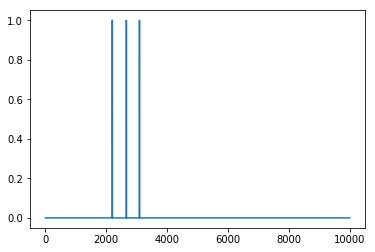